In [ ]:
install.packages("couchDB") ### One time only as the package is installed for the user

In [1]:
library("couchDB")
options(warn=-1) #turn off warnings globally for the notebook
#options(warn=0) #turn on warnings 

Loading required package: RCurl
Loading required package: bitops

Attaching package: 'RCurl'

The following object is masked from 'package:SparkR':

    base64

Loading required package: httr
Loading required package: rjson


In [2]:
sqlContext <- sparkRSQL.init(sc)

In [3]:
myconn <- couch_http_connection(host = "XXXX", port = 443, https = TRUE, service = "cloudant", user = "XXXX", password = "XXXX")

In [4]:
couch_list_databases(myconn)

[1] "_warehouser"                                  
[2] "pipe_db"                                      
[3] "reddit_ibmama_top_comments_only"              
[4] "reddit_regularreddit_top_comments_and_replies"
[5] "reddit_regularreddit_top_comments_only"

In [5]:
print(myconn)

$couch_http_host
[1] "b4713dfe-123e-4299-93b1-c7cd01968518-bluemix.cloudant.com"

$couch_http_port
[1] 443

$secure
[1] TRUE

$service
[1] "cloudant"

$user
[1] "b4713dfe-123e-4299-93b1-c7cd01968518-bluemix"

$password
[1] "3e4836b2172e03c084fb9b57d0c81b8e766b4e9f37ae43201e464a867f48dc74"

attr(,"class")
[1] "couch_connection"


In [6]:
results <- couch_fetch(myconn, database = "reddit_regularreddit_top_comments_and_replies/_all_docs", key = NULL, myOpts = NULL)
results_df <- data.frame(results)
df <- createDataFrame(sqlContext, results_df)

In [7]:
printSchema(df)

root
 |-- total_rows: integer (nullable = true)
 |-- offset: integer (nullable = true)
 |-- rows_id: string (nullable = true)
 |-- rows_key: string (nullable = true)
 |-- rows_rev: string (nullable = true)
 |-- rows_id_1: string (nullable = true)
 |-- rows_key_1: string (nullable = true)
 |-- rows_rev_1: string (nullable = true)
 |-- rows_id_2: string (nullable = true)
 |-- rows_key_2: string (nullable = true)
 |-- rows_rev_2: string (nullable = true)
 |-- rows_id_3: string (nullable = true)
 |-- rows_key_3: string (nullable = true)
 |-- rows_rev_3: string (nullable = true)


In [8]:
typeof(results)

[1] "list"

In [9]:
print(results)

$total_rows
[1] 4

$offset
[1] 0

$rows
$rows[[1]]
$rows[[1]]$id
[1] "_design/Top comments and replies"

$rows[[1]]$key
[1] "_design/Top comments and replies"

$rows[[1]]$value
$rows[[1]]$value$rev
[1] "1-edc6f6bb0062260ecf1160c81872efdd"



$rows[[2]]
$rows[[2]]$id
[1] "f4f7cfa487898608fff6eb639fe6ed26"

$rows[[2]]$key
[1] "f4f7cfa487898608fff6eb639fe6ed26"

$rows[[2]]$value
$rows[[2]]$value$rev
[1] "1-c0be345c89577577cdeb301328d9e4f5"



$rows[[3]]
$rows[[3]]$id
[1] "f4f7cfa487898608fff6eb639fe6efd3"

$rows[[3]]$key
[1] "f4f7cfa487898608fff6eb639fe6efd3"

$rows[[3]]$value
$rows[[3]]$value$rev
[1] "1-6b0c4d5588c127c57136dd6c917881cc"



$rows[[4]]
$rows[[4]]$id
[1] "f4f7cfa487898608fff6eb639fe6f112"

$rows[[4]]$key
[1] "f4f7cfa487898608fff6eb639fe6f112"

$rows[[4]]$value
$rows[[4]]$value$rev
[1] "1-aa11fd3a2efdfd711b6b63a8973cb53b"






In [10]:
keys_list <- data.frame(results)
print(keys_list[,'total_rows'])
print(keys_list[,'rows.key.3'])
rows_df_2 <- data.frame()

    for (i in 1:(keys_list[,'total_rows'] - 1) ){
        print(i)
        key <- paste('rows.key.',i,sep="")
        docs <- couch_fetch(myconn, database = "reddit_regularreddit_top_comments_and_replies", key = keys_list[,key], myOpts = NULL)   
 
        rows_df <- data.frame(docs)  
        rows_df_2 <- rbind(rows_df_2,rows_df)
    
    }

df2 <- createDataFrame(sqlContext, rows_df_2)
printSchema(df2)
showDF(df2)

[1] 4
[1] f4f7cfa487898608fff6eb639fe6f112
Levels: f4f7cfa487898608fff6eb639fe6f112
[1] 1
[1] 2
[1] 3
root
 |-- X_id: string (nullable = true)
 |-- X_rev: string (nullable = true)
 |-- author: string (nullable = true)
 |-- created: integer (nullable = true)
 |-- edited: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- Anger: string (nullable = true)
 |-- Disgust: string (nullable = true)
 |-- Fear: string (nullable = true)
 |-- Joy: string (nullable = true)
 |-- Sadness: string (nullable = true)
 |-- Analytical: string (nullable = true)
 |-- Confident: string (nullable = true)
 |-- Tentative: string (nullable = true)
 |-- Openness: string (nullable = true)
 |-- Conscientiousness: string (nullable = true)
 |-- Extraversion: string (nullable = true)
 |-- Agreeableness: string (nullable = true)
 |-- Emotional_Range: string (nullable = true)
 |-- pt_type: string (nullable = true)
+--------------------+

### Histogram

Barplot displaying histogram of comments by sentiments > 70% by using SparkR SQL.

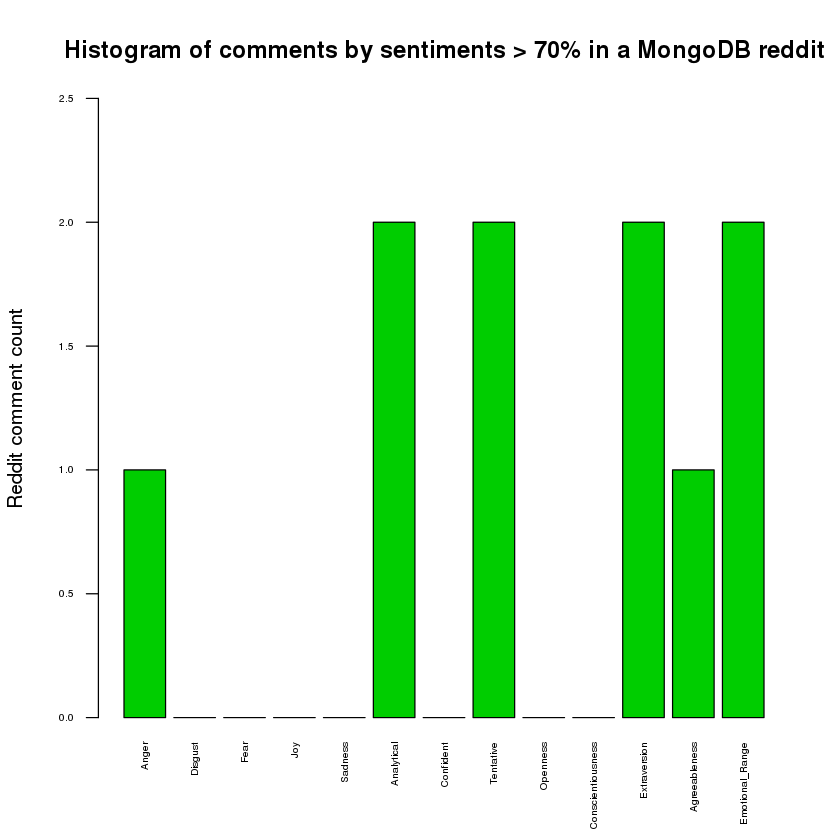

In [11]:
registerTempTable(df2,"reddit")
sentimentDistribution <- list()
columns <- colnames(df2[,9:21])
count <- list()
    
    for(i in 1:length(columns)){
        query <- paste('SELECT count(*) as sentCount FROM reddit where ',columns[i],' > 70')
        df3 <- sql(sqlContext,query)
        collected <- collect(df3)
        count[columns[i]] <- collected$sentCount
    }

distribution <- unlist(count)
par(las=2)
barplot(distribution, main="Histogram of comments by sentiments > 70% in a MongoDB reddit",col=139, ylim=c(0,2.5),cex.axis=0.5,cex.names=0.5,ylab="Reddit comment count")

### Comments by sentiment

Collect and list comments by sentiment to see where specific examples fall by using SparkR and R Dataframe operations. Reading these results lets you reflect upon how participants feel and react. Some comments appear in multiple sentiment groups.

In [12]:
for(i in 1:length(columns)){
    columnset <- filter(df2,paste(columns[i], ' > 70') )
    if(count(columnset) > 0){
    print('-----------------------------------------------------------------------------')
    print(columns[i])
    print('-----------------------------------------------------------------------------')
    comments <- as.data.frame(select(columnset,"author","text")) ## not helpful print prints columnwise
        for(j in 1:length(comments)){
            print(paste("Author: ",comments[j,1]))
            print(paste("Comments: ",comments[j,2]))
        }
    }
}

[1] "-----------------------------------------------------------------------------"
[1] "Anger"
[1] "-----------------------------------------------------------------------------"
[1] "Author:  grauenwolf"
[1] "Comments:  I don't see how this can't end badly. When MongoDB starts losing data on servers they maintain, the lawsuits are going to start flying. And they can't use their normal \"you misconfigured it\" excuse.\n\nEDIT:\n\nFrom their terms of service\n\n&gt; 8. No Warranty. The service is provided on an \"AS IS\" and \"AS AVAILABLE\" basis and with no representation or warranty of any kind. Except to the extent prohibited by law, we disclaim any implied or statutory warranty, including any implied warranty of merchantability or fitness for a particular purpose, and any warranty arising out of any course of dealing or usage of trade.\n\n&gt; 10. Indemnification. You will defend, indemnify, and hold harmless us, our affiliates and licensors, and each of their respective employees